## Some helper functions

### Dependencies and constants

In [29]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Input
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import regularizers



# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
# np.random.seed(hash(student1 + student2) % 2**32)
np.random.seed(237699 + 279617)
subset_of_classes = np.random.choice(range(10), 5, replace = False)
print("Subset of classes selected: {}".format(', '.join([str(subset_of_classes[i]) for i in range(5)])))

Subset of classes selected: 1, 0, 5, 6, 3


### Plotting

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [31]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)
print("Full Train data size: {}\nFull Test data size: {}".format(x_train_all.shape,x_test_all.shape))

Full Train data size: (73257, 256)
Full Test data size: (26032, 256)


### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [32]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

print("Sampled Train data size: {}\nSampled Test data size: {}".format(x_train.shape,x_test.shape))

Sampled Train data size: (43226, 256)
Sampled Test data size: (15767, 256)


Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

In [33]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [34]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [35]:
couleur = ['b','g','r','c','m','y','w','k']

## First Model :

### Description

Model definition :

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Choose 450 epochs.


### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
Train on 43226 samples, validate on 15767 samples
Epoch 1/450
43226/43226 [==============================] - 0s - loss: 1.5708 - acc: 0.3198 - val_loss: 1.5662 - val_acc: 0.3227
Epoch 2/450
43226/43226 [==============================] - 0s - loss: 1.5576 - acc: 0.3348 - val_loss: 1.5552 - val_acc: 0.3269
Epoch 3/450
43226/43226 [==============================] - 0s - loss: 1.5504 - acc: 0.3374 - val_loss: 1.5476 - val_acc: 0.33160.337
Epoch 4/450
43226/43226 [==============================] - 0s - loss: 1.5449 - acc: 0.3406 - val_loss: 1.5428 - val_acc: 0.3361
Epoch 5/450
43226/43226 [==============================] - 0s - loss: 1.5407 - acc: 0.3416 - val_loss

43226/43226 [==============================] - 0s - loss: 1.4965 - acc: 0.3839 - val_loss: 1.5174 - val_acc: 0.3703
Epoch 61/450
43226/43226 [==============================] - 0s - loss: 1.4963 - acc: 0.3847 - val_loss: 1.5181 - val_acc: 0.3727
Epoch 62/450
43226/43226 [==============================] - 0s - loss: 1.4959 - acc: 0.3851 - val_loss: 1.5185 - val_acc: 0.3660
Epoch 63/450
43226/43226 [==============================] - 0s - loss: 1.4957 - acc: 0.3857 - val_loss: 1.5175 - val_acc: 0.3702
Epoch 64/450
43226/43226 [==============================] - 0s - loss: 1.4954 - acc: 0.3851 - val_loss: 1.5184 - val_acc: 0.3745
Epoch 65/450
43226/43226 [==============================] - 0s - loss: 1.4952 - acc: 0.3861 - val_loss: 1.5185 - val_acc: 0.3710
Epoch 66/450
43226/43226 [==============================] - 0s - loss: 1.4950 - acc: 0.3859 - val_loss: 1.5173 - val_acc: 0.3708
Epoch 67/450
43226/43226 [==============================] - 0s - loss: 1.4948 - acc: 0.3860 - val_loss: 1.5176

43226/43226 [==============================] - 0s - loss: 1.4864 - acc: 0.3969 - val_loss: 1.5207 - val_acc: 0.3770
Epoch 124/450
43226/43226 [==============================] - 0s - loss: 1.4863 - acc: 0.3970 - val_loss: 1.5220 - val_acc: 0.3780
Epoch 125/450
43226/43226 [==============================] - 0s - loss: 1.4862 - acc: 0.3967 - val_loss: 1.5214 - val_acc: 0.3765
Epoch 126/450
43226/43226 [==============================] - 0s - loss: 1.4862 - acc: 0.3965 - val_loss: 1.5212 - val_acc: 0.3788
Epoch 127/450
43226/43226 [==============================] - 0s - loss: 1.4861 - acc: 0.3971 - val_loss: 1.5218 - val_acc: 0.3798
Epoch 128/450
43226/43226 [==============================] - 0s - loss: 1.4860 - acc: 0.3973 - val_loss: 1.5218 - val_acc: 0.3811
Epoch 129/450
43226/43226 [==============================] - 0s - loss: 1.4858 - acc: 0.3976 - val_loss: 1.5222 - val_acc: 0.3786
Epoch 130/450
43226/43226 [==============================] - 0s - loss: 1.4856 - acc: 0.3977 - val_loss:

43226/43226 [==============================] - 0s - loss: 1.4819 - acc: 0.4020 - val_loss: 1.5243 - val_acc: 0.3845
Epoch 187/450
43226/43226 [==============================] - 0s - loss: 1.4818 - acc: 0.4024 - val_loss: 1.5240 - val_acc: 0.3804
Epoch 188/450
43226/43226 [==============================] - 0s - loss: 1.4817 - acc: 0.4016 - val_loss: 1.5250 - val_acc: 0.3858
Epoch 189/450
43226/43226 [==============================] - 0s - loss: 1.4817 - acc: 0.4024 - val_loss: 1.5247 - val_acc: 0.3857
Epoch 190/450
43226/43226 [==============================] - 0s - loss: 1.4816 - acc: 0.4030 - val_loss: 1.5240 - val_acc: 0.3819
Epoch 191/450
43226/43226 [==============================] - 0s - loss: 1.4816 - acc: 0.4025 - val_loss: 1.5241 - val_acc: 0.3825
Epoch 192/450
43226/43226 [==============================] - 0s - loss: 1.4815 - acc: 0.4027 - val_loss: 1.5242 - val_acc: 0.3826
Epoch 193/450
43226/43226 [==============================] - 0s - loss: 1.4815 - acc: 0.4028 - val_loss:

43226/43226 [==============================] - 0s - loss: 1.4791 - acc: 0.4069 - val_loss: 1.5265 - val_acc: 0.3854
Epoch 250/450
43226/43226 [==============================] - 0s - loss: 1.4790 - acc: 0.4060 - val_loss: 1.5259 - val_acc: 0.3840
Epoch 251/450
43226/43226 [==============================] - 0s - loss: 1.4790 - acc: 0.4063 - val_loss: 1.5260 - val_acc: 0.3843
Epoch 252/450
43226/43226 [==============================] - 0s - loss: 1.4789 - acc: 0.4066 - val_loss: 1.5263 - val_acc: 0.3854
Epoch 253/450
43226/43226 [==============================] - 0s - loss: 1.4789 - acc: 0.4066 - val_loss: 1.5263 - val_acc: 0.3838
Epoch 254/450
43226/43226 [==============================] - 0s - loss: 1.4789 - acc: 0.4058 - val_loss: 1.5261 - val_acc: 0.3843
Epoch 255/450
43226/43226 [==============================] - 0s - loss: 1.4789 - acc: 0.4066 - val_loss: 1.5265 - val_acc: 0.3830
Epoch 256/450
43226/43226 [==============================] - 0s - loss: 1.4788 - acc: 0.4067 - val_loss:

43226/43226 [==============================] - 0s - loss: 1.4770 - acc: 0.4090 - val_loss: 1.5282 - val_acc: 0.3817
Epoch 313/450
43226/43226 [==============================] - 0s - loss: 1.4771 - acc: 0.4088 - val_loss: 1.5276 - val_acc: 0.3852
Epoch 314/450
43226/43226 [==============================] - 0s - loss: 1.4771 - acc: 0.4078 - val_loss: 1.5280 - val_acc: 0.3872
Epoch 315/450
43226/43226 [==============================] - 0s - loss: 1.4770 - acc: 0.4077 - val_loss: 1.5276 - val_acc: 0.3822
Epoch 316/450
43226/43226 [==============================] - 0s - loss: 1.4770 - acc: 0.4085 - val_loss: 1.5280 - val_acc: 0.3869
Epoch 317/450
43226/43226 [==============================] - 0s - loss: 1.4769 - acc: 0.4093 - val_loss: 1.5277 - val_acc: 0.3856
Epoch 318/450
43226/43226 [==============================] - 0s - loss: 1.4770 - acc: 0.4083 - val_loss: 1.5280 - val_acc: 0.3856
Epoch 319/450
43226/43226 [==============================] - 0s - loss: 1.4769 - acc: 0.4086 - val_loss:

43226/43226 [==============================] - 0s - loss: 1.4755 - acc: 0.4090 - val_loss: 1.5285 - val_acc: 0.3857
Epoch 376/450
43226/43226 [==============================] - 0s - loss: 1.4756 - acc: 0.4095 - val_loss: 1.5284 - val_acc: 0.3850
Epoch 377/450
43226/43226 [==============================] - 0s - loss: 1.4756 - acc: 0.4099 - val_loss: 1.5281 - val_acc: 0.3836
Epoch 378/450
43226/43226 [==============================] - 0s - loss: 1.4755 - acc: 0.4095 - val_loss: 1.5290 - val_acc: 0.3866
Epoch 379/450
43226/43226 [==============================] - 0s - loss: 1.4755 - acc: 0.4101 - val_loss: 1.5290 - val_acc: 0.3867
Epoch 380/450
43226/43226 [==============================] - 0s - loss: 1.4755 - acc: 0.4101 - val_loss: 1.5282 - val_acc: 0.3836
Epoch 381/450
43226/43226 [==============================] - 0s - loss: 1.4755 - acc: 0.4090 - val_loss: 1.5285 - val_acc: 0.3840
Epoch 382/450
43226/43226 [==============================] - 0s - loss: 1.4754 - acc: 0.4104 - val_loss:

43226/43226 [==============================] - 0s - loss: 1.4744 - acc: 0.4117 - val_loss: 1.5297 - val_acc: 0.3842
Epoch 439/450
43226/43226 [==============================] - 0s - loss: 1.4743 - acc: 0.4105 - val_loss: 1.5301 - val_acc: 0.3847
Epoch 440/450
43226/43226 [==============================] - 0s - loss: 1.4744 - acc: 0.4107 - val_loss: 1.5295 - val_acc: 0.3861
Epoch 441/450
43226/43226 [==============================] - 0s - loss: 1.4743 - acc: 0.4109 - val_loss: 1.5298 - val_acc: 0.3858
Epoch 442/450
43226/43226 [==============================] - 0s - loss: 1.4743 - acc: 0.4099 - val_loss: 1.5298 - val_acc: 0.3868
Epoch 443/450
43226/43226 [==============================] - 0s - loss: 1.4743 - acc: 0.4113 - val_loss: 1.5290 - val_acc: 0.3842
Epoch 444/450
43226/43226 [==============================] - 0s - loss: 1.4742 - acc: 0.4114 - val_loss: 1.5297 - val_acc: 0.3826
Epoch 445/450
43226/43226 [==============================] - 0s - loss: 1.4743 - acc: 0.4117 - val_loss:

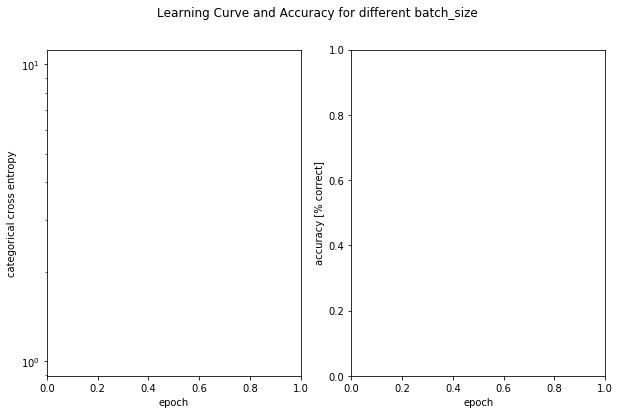

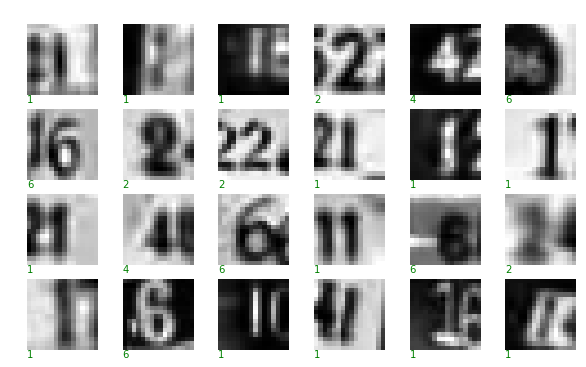

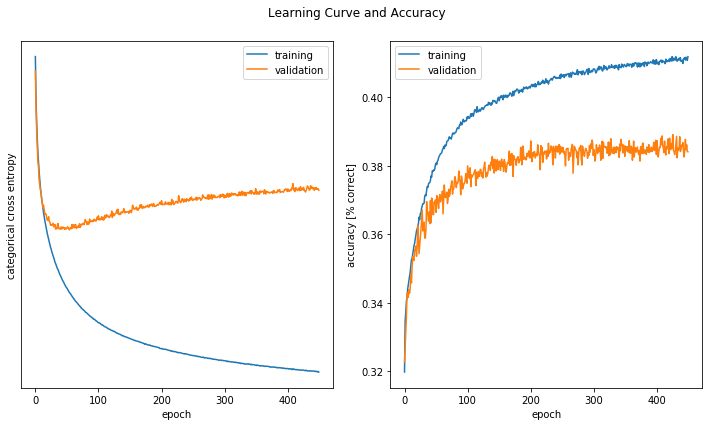

In [36]:
####################################################################################################
# Model and plot
####################################################################################################
model = Sequential()
model.add(Dense(5, activation='softmax', input_shape=x_train.shape[1:]))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=450,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history, 'Learning Curve and Accuracy')
plt.show()

First way : Number of errors:  9710


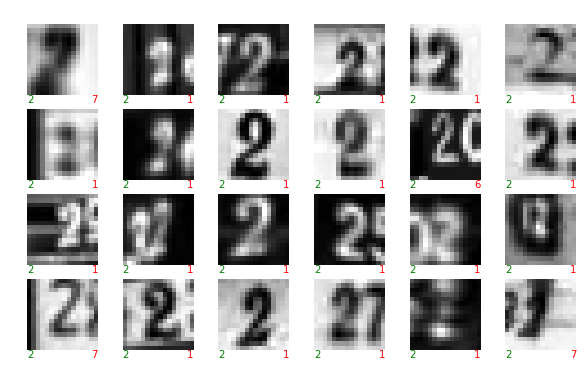

In [37]:
####################################################################################################
# Determine the indices of all test images that are misclassified by the fitted model
####################################################################################################

prediction=model.predict(x_test, batch_size=None, verbose=0)
idx=[]
error=0
for i in range (y_test[:,0].size):
    for j in range (y_test[0,:].size):
        if ((y_test[i][j]==1) & (max(prediction[i])!=prediction[i][j])):
            idx.append(i)
            error=error+1
            break
print ('First way : Number of errors: ',error)
### plot some of them using the function ###
plot_some_samples(x_test, y_test, prediction, idx[0:30]  ,label_mapping = subset_of_classes)
plt.show()

## Second Model: One hidden layer, different learning rate 

1. Use one hidden layer with 64 units and the 'relu' activation.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent.


### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 1.47334080674
Test accuracy: 0.37591171434


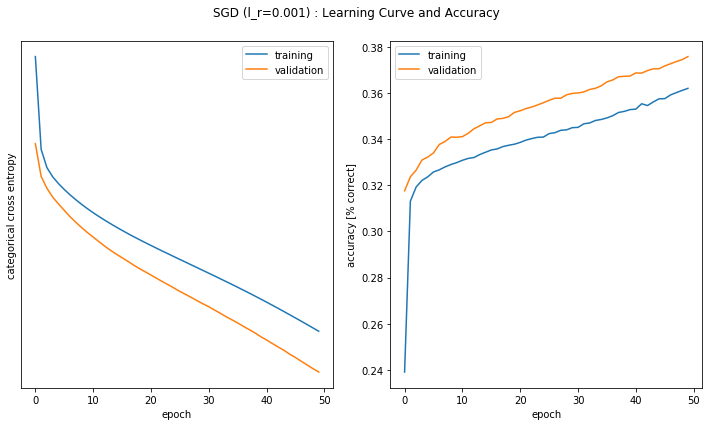

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.855415933866
Test accuracy: 0.723346229497


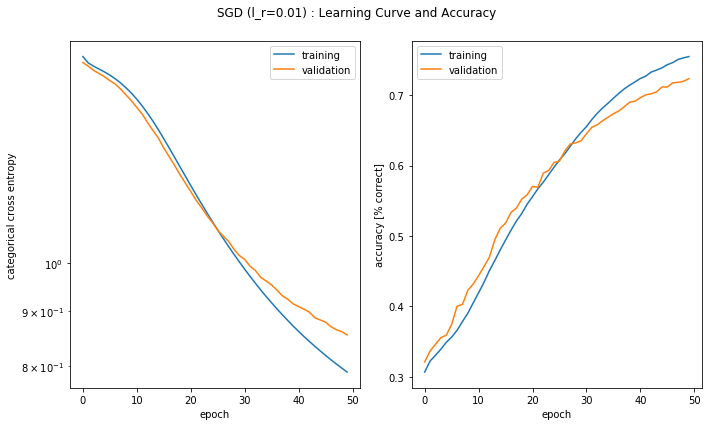

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.572615154122
Test accuracy: 0.833639880779


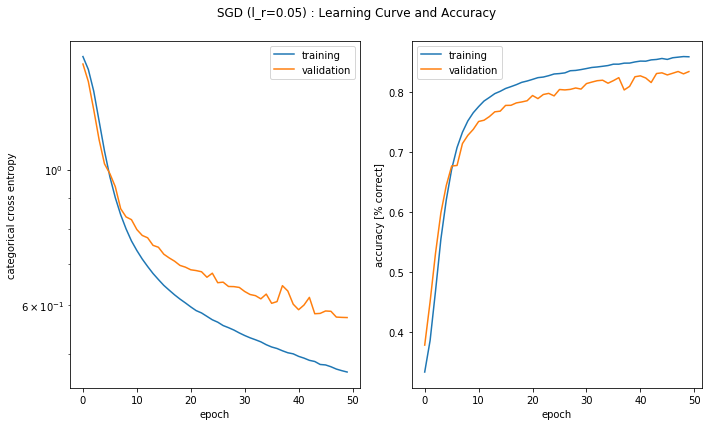

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.497994215289
Test accuracy: 0.864971142274


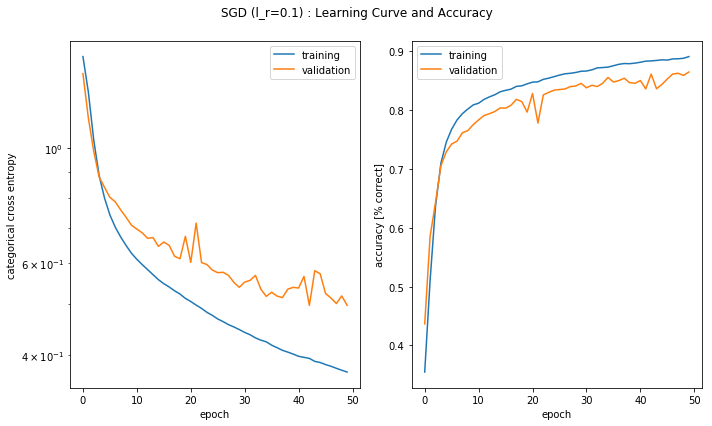

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.531642244058
Test accuracy: 0.868903405848


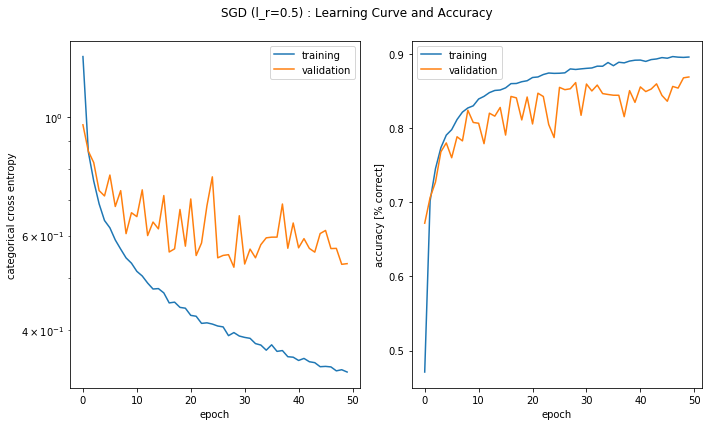

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.564164691317
Test accuracy: 0.856345531765


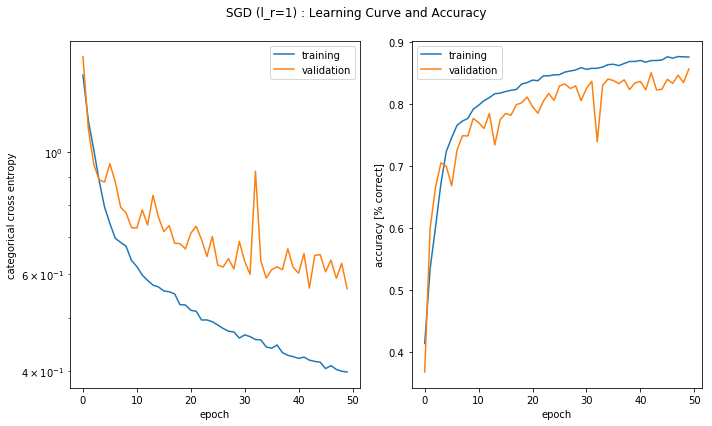

In [38]:
####################################################################################################
# Fit model with different Learning Rate
####################################################################################################

### Learning Rate ###
l_r=[0.001,0.01,0.05,0.1,0.5,1]

histo=[]

####################################################################################################
# Simulation for the different learning rate
####################################################################################################
for i in range (len(l_r)):
    model_1 = Sequential()
    model_1.add(Dense(64, activation='relu', input_shape=x_train.shape[1:]))
    model_1.add(Dense(5, activation='softmax'))

    # Inspect the model #
    model_1.summary()

    model_1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=l_r[i]),
              metrics=['accuracy'])

    history_1 = model_1.fit(x_train, y_train,
                        batch_size=128,
                        epochs=50,
                        verbose=0,
                        validation_data=(x_test, y_test))
    histo.append(history_1)

    score = model_1.evaluate(x_test, y_test, verbose=0)

    # plot #
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plot_history(history_1, 'SGD (l_r={0}) : Learning Curve and Accuracy'.format(l_r[i]))
    plt.show()

We can make the following observations thanks to the graphs :

A) Very Large : Large learning rate will create an oscillation for the loss function around the minimum due to large gradient update.  It is really not optimal because due to this large learning rate, the convergence will not be found. On the contrary, it can create a divergence due to large step value.

B) Very small : In fact, with 50 epochs and a little learning rate, the model has not the time to learn well. The learning rate is small and thus as the changes between epochs will be too small, it will converge very slowly and may sometimes platues at the same point infinitely. We will rather need a huge number of epochs to converge to the best values and thus this is not optimal.


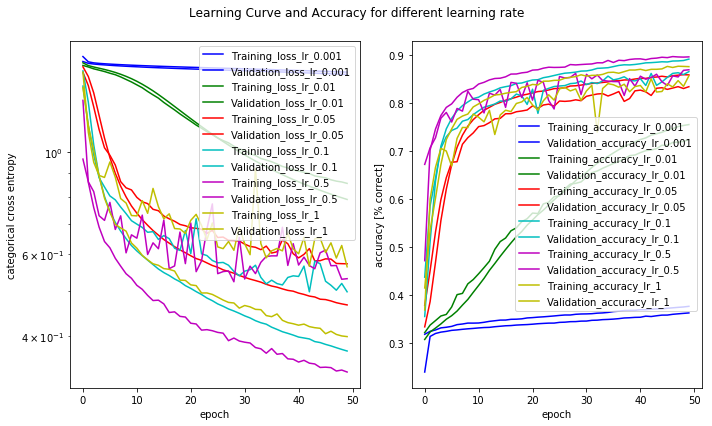

In [39]:
fig, ax1, ax2 = prepare_standardplot('Learning Curve and Accuracy for different learning rate', 'epoch')
for i in range (len(histo)):
    ax1.plot(histo[i].history['loss'], label = "Training_loss_lr_{}".format(l_r[i]),color=couleur[i])
    ax1.plot(histo[i].history['val_loss'], label = "Validation_loss_lr_{}".format(l_r[i]),color=couleur[i])
    ax2.plot(histo[i].history['acc'], label = "Training_accuracy_lr_{}".format(l_r[i]),color=couleur[i])
    ax2.plot(histo[i].history['val_acc'], label = "Validation_accuracy_lr_{}".format(l_r[i]),color=couleur[i])
finalize_standardplot(fig, ax1, ax2)
plt.show()

 ## Second Model: One hidden layer, different optimizers 
3. Replace the stochastic gradient descent optimizer with the other optimizers (adagrad, adadelta ...)
4. Plot the learning curves.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.490291558771
Test accuracy: 0.869093676666


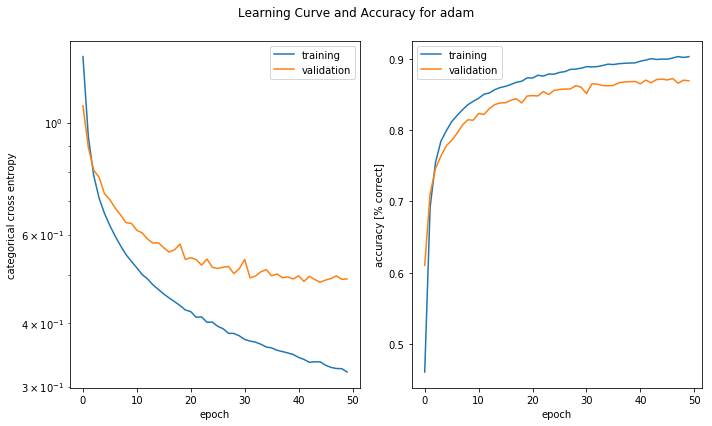

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.632947198031
Test accuracy: 0.80991945205


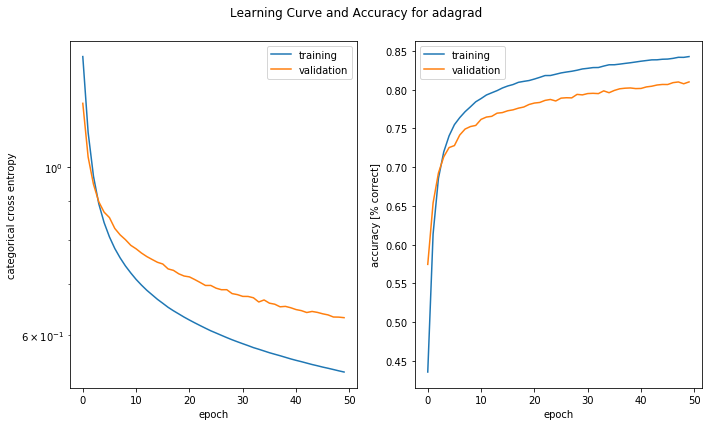

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.488502570787
Test accuracy: 0.867381239328


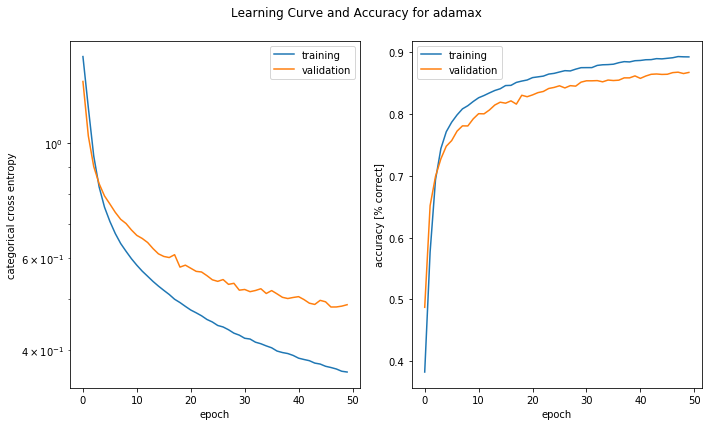

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.559462805851
Test accuracy: 0.839665123374


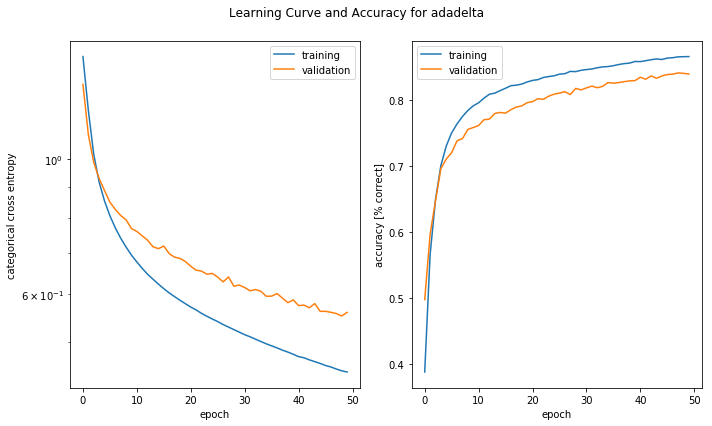

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.823042686331
Test accuracy: 0.741231686449


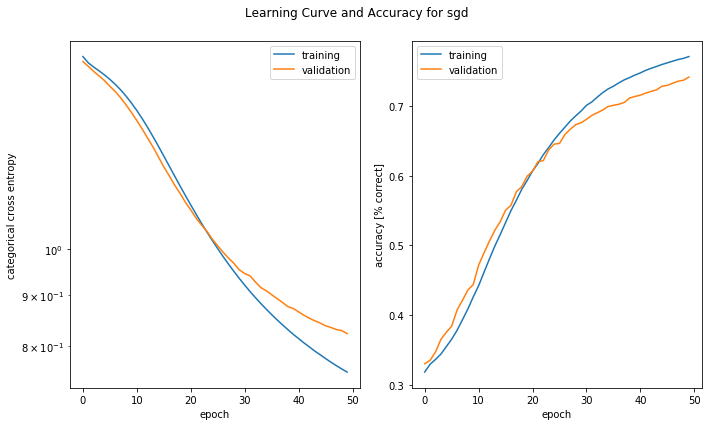

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.493134235907
Test accuracy: 0.880763620219


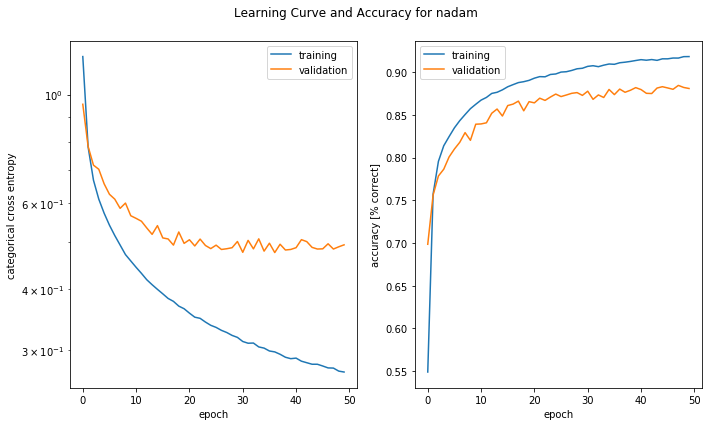

In [40]:
####################################################################################################
# Fit model with different optimizers
####################################################################################################

### Optimizers ###
opti=['adam','adagrad','adamax', 'adadelta', 'sgd', 'nadam']

histog=[]

####################################################################################################
# Simulation for the different Optimizers
####################################################################################################
for i in range (len(opti)):
    model_2 = Sequential()
    model_2.add(Dense(64, activation='relu', input_shape=x_train.shape[1:]))
    model_2.add(Dense(5, activation='softmax'))

    # Inspect the model #
    model_2.summary()

    model_2.compile(loss='categorical_crossentropy',
              optimizer=opti[i],
              metrics=['accuracy'])

    history_2 = model_2.fit(x_train, y_train,
                        batch_size=128,
                        epochs=50,
                        verbose=0,
                        validation_data=(x_test, y_test))
    histog.append(history_2)

    score = model_2.evaluate(x_test, y_test, verbose=0)

    # plot #
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plot_history(history_2, 'Learning Curve and Accuracy for {}'.format(opti[i]))
    plt.show()

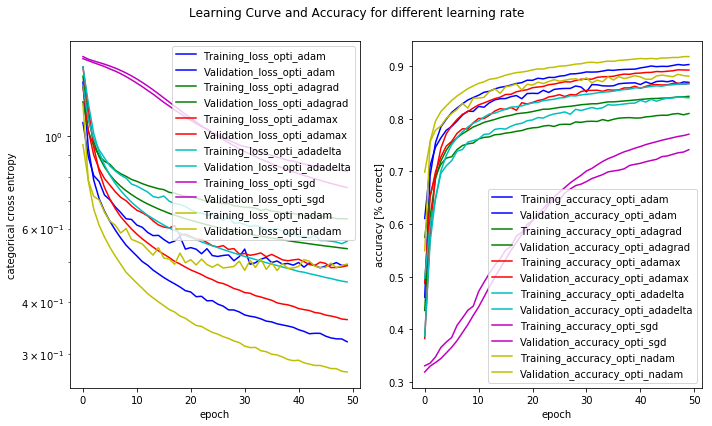

In [41]:
fig, ax1, ax2 = prepare_standardplot('Learning Curve and Accuracy for different learning rate', 'epoch')
for i in range (len(histog)):
    ax1.plot(histog[i].history['loss'], label = "Training_loss_opti_{}".format(opti[i]),color=couleur[i])
    ax1.plot(histog[i].history['val_loss'], label = "Validation_loss_opti_{}".format(opti[i]),color=couleur[i])
    ax2.plot(histog[i].history['acc'], label = "Training_accuracy_opti_{}".format(opti[i]),color=couleur[i])
    ax2.plot(histog[i].history['val_acc'], label = "Validation_accuracy_opti_{}".format(opti[i]),color=couleur[i])
finalize_standardplot(fig, ax1, ax2)
plt.show()

 ## Second Model: One hidden layer, different bacth_size 
3. Change the bacth size for model with SGD
4. Plot the learning curves.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.495834980971
Test accuracy: 0.876767933055


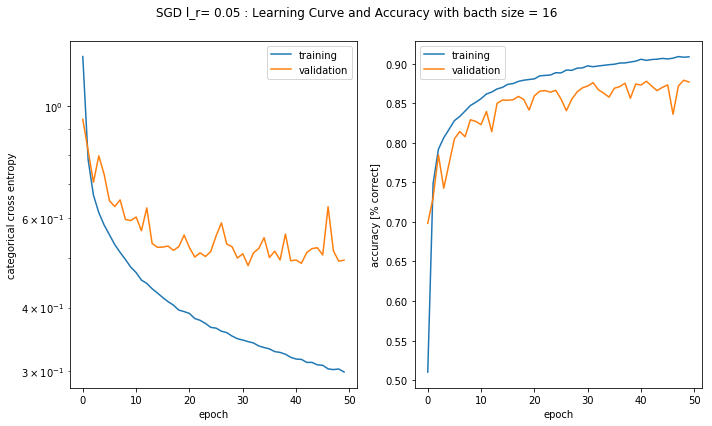

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.476139775132
Test accuracy: 0.879495148109


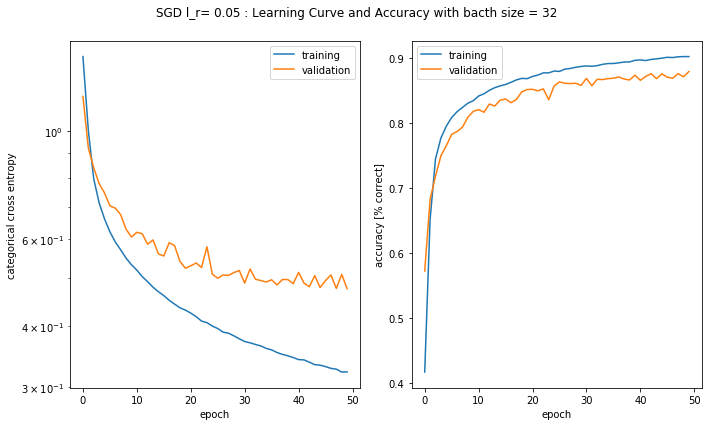

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.511392503291
Test accuracy: 0.859833830167


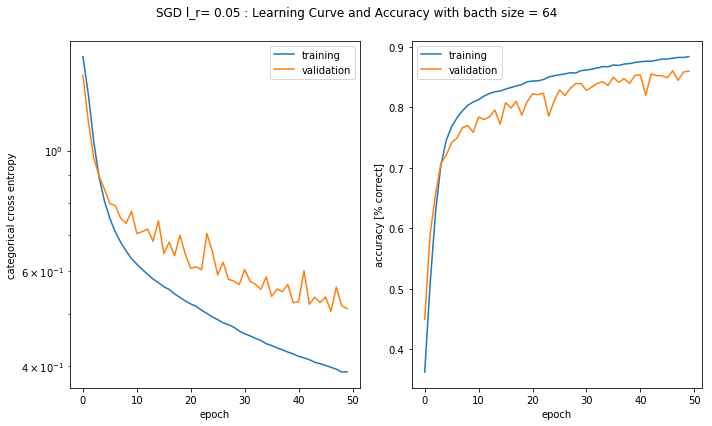

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.581839810553
Test accuracy: 0.830151582434


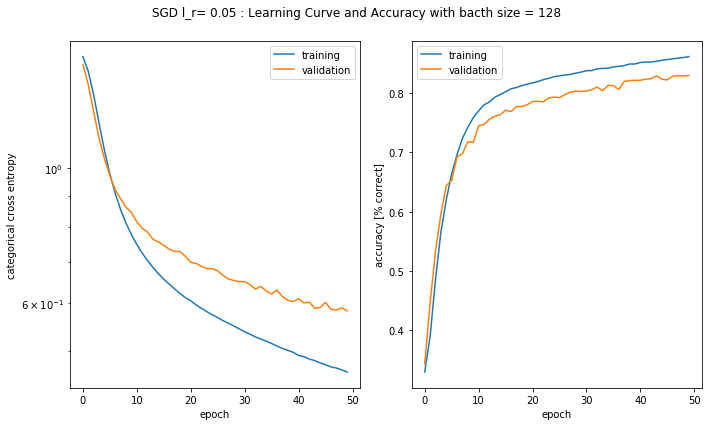

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.686661008345
Test accuracy: 0.791146064595


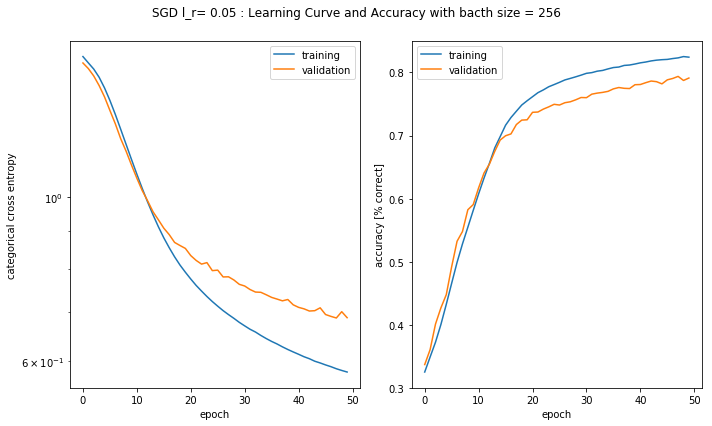

In [42]:
####################################################################################################
# Different bacth size
####################################################################################################

###################Batch size######################
batch_=[16,32,64,128,256]
###################################################

hist=[]

################### Model #########################
for i in range (len(batch_)):
    model_sgd = Sequential()
    model_sgd.add(Dense(64, activation='relu', input_shape=x_train.shape[1:]))
    model_sgd.add(Dense(5, activation='softmax'))

    model_sgd.summary()

    model_sgd.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.05),
              metrics=['accuracy'])

    history_sgd = model_sgd.fit(x_train, y_train,
                        batch_size=batch_[i],
                        epochs=50,
                        verbose=0,
                        validation_data=(x_test, y_test))

    score = model_sgd.evaluate(x_test, y_test, verbose=0)

    hist.append(history_sgd)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plot_history(history_sgd, 'SGD l_r= 0.05 : Learning Curve and Accuracy with bacth size = {}'.format(batch_[i]))
    plt.show()
    

In [43]:
fig, ax1, ax2 = prepare_standardplot('Learning Curve and Accuracy for different batch_size', 'epoch')
for i in range (len(batch_)):
    ax1.plot(hist[i].history['loss'], label = "Training_loss_batch_{}".format(batch_[i]),color=couleur[i])
    ax1.plot(hist[i].history['val_loss'], label = "Validation_loss_batch_{}".format(batch_[i]),color=couleur[i])
    ax2.plot(hist[i].history['acc'], label = "Training_accuracy_batch_{}".format(batch_[i]),color=couleur[i])
    ax2.plot(hist[i].history['val_acc'], label = "Validation_accuracy_batch_{}".format(batch_[i]),color=couleur[i])
finalize_standardplot(fig, ax1, ax2)

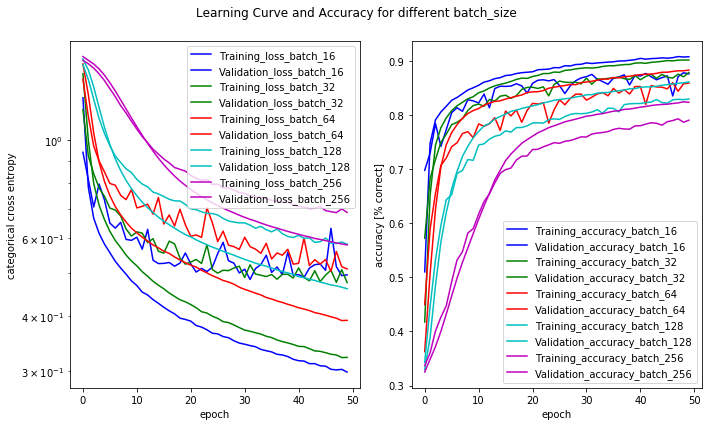

In [44]:
plt.show()

## Using early stopping 

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. 
We can use that to be rapid in our simulation and to compare time to arrive to convergence.

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.487656670585
Test accuracy: 0.870806114051


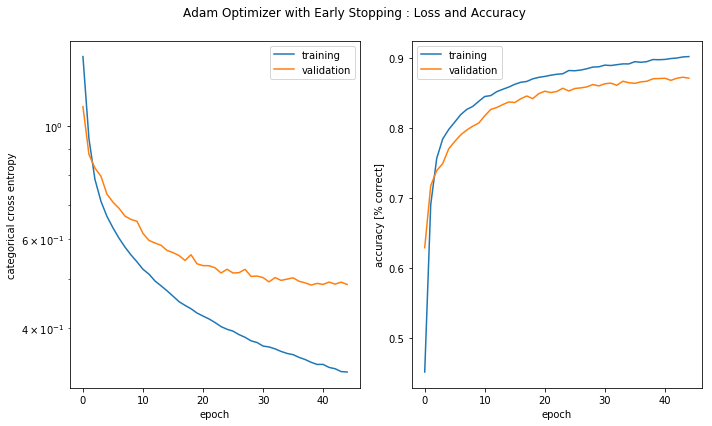

In [45]:
####################################################################################################
# EARLY STOPPING : ADAM OPTIMIZER
####################################################################################################
model_early = Sequential()
model_early.add(Dense(64, activation='relu', input_shape=x_train.shape[1:]))
model_early.add(Dense(5, activation='softmax'))

model_early.summary()

call= keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')

model_early.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

history_early = model_early.fit(x_train, y_train,  callbacks=[call],
                    batch_size=128,
                    epochs=300,
                    verbose=0,
                    validation_data=(x_test, y_test))

score = model_early.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history_early, 'Adam Optimizer with Early Stopping : Loss and Accuracy ')
plt.show()